In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import pathlib
import sisepuede.core.support_classes as sc
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import utils.common_data_needs as cdn
import warnings
warnings.filterwarnings("ignore")



plt.style.use("dark_background", )


In [29]:
dict_ssp = cdn._setup_sisepuede_elements()

matt = dict_ssp.get("model_attributes", )
models = dict_ssp.get("models", )
regions = dict_ssp.get("regions", )
time_periods = dict_ssp.get("time_periods", )

# setup region
_REGION_NAME = "uganda"
_REGION_ISO = regions.return_region_or_iso(_REGION_NAME, return_type = "iso")


# SET SOME GLOBALS

# fields
_FIELD_ERA_TECH = "technology_era"
_FIELD_OPERATIONAL_LIFE = "operational_life"
_FIELD_SSP_ENTC = matt.get_subsector_attribute("Energy Technology", "pycategory_primary_element")

# flags
_FLAG_DROP = "_DROP"
_FLAG_OVERALL_CAPACITY = "Overall Total Installed Capacity"

# units associated with input data
_UNITS_DATASET_ERA = "MW"

# Load data we'll work with

`20240604_STA_InstalledGenerationCapacity2000_Todate.xlsx` is sourced from the [Uganda Electricity Regulatory Authority](https://www.era.go.ug/installed-capacity/)

In [120]:
##  FUNCTIONS

def get_era_installed_capacity(
    path: pathlib.Path,
) -> pd.DataFrame:
    """Retrieve the installed capacity DataFrame. Formats for analysis and adds
        blank fields for future estimates of retirements
    """


    ##  GET THE RAW EXCEL

    df_installed_capacity = (
        pd.read_excel(path, skiprows = 8, )
        .drop(columns = ["Unnamed: 0", "Unnamed: 1"], )
        .rename(columns = {"Unnamed: 2": _FIELD_ERA_TECH}, )
    )

    fields_capacity_year = [x for x in df_installed_capacity.columns if str(x).isnumeric()]

    
    ##  EXTEND FIELDS
    
    new_years_max = attr_entc.table[_FIELD_OPERATIONAL_LIFE].max()

    new_fields = np.array(fields_capacity_year).max()
    new_fields = (
        np.arange(
            new_fields + 1,
            new_fields + new_years_max + 1
        )
        .astype(int)
    )
    
    df_installed_capacity[new_fields] = np.nan
    fields_year = fields_capacity_year + list(new_fields)
    
    #
    out = (
        df_installed_capacity, 
        fields_capacity_year, 
        fields_year, 
    )

    return out



    
# get some SISEPUEDE elements
attr_entc = matt.get_attribute_table("Energy Technology")
modvar_msp = matt.get_variable(
     models.model_enerprod.modvar_entc_nemomod_min_share_production,
)
modvar_rc = matt.get_variable(
    models.model_enerprod.modvar_entc_nemomod_residual_capacity,
)

# base dataset
df_uganda = cdn.get_raw_ssp_inputs()
df_installed_capacity, fields_capacity_year_base, fields_ic_year = get_era_installed_capacity(
    cdn._PATH_INPUTS.joinpath("era", "20240604_STA_InstalledGenerationCapacity2000_Todate.xlsx")
)

##  Assign categories in Uganda ERA to SISEPUEDE

####  Note on allocation thermal:
- MinShareProduction from IEA shows hydro, solar, and oil only
- HFO in Excel is Heavy Fuel Oil
- We allocate _all_ thermal to pp_oil

In [42]:
# check MSP from IEA
df = modvar_msp.get_from_dataframe(df_uganda, )
df[[x for x in df.columns if df[x].max() > 0]].tail()

,nemomod_entc_frac_min_share_production_pp_hydropower,nemomod_entc_frac_min_share_production_pp_oil,nemomod_entc_frac_min_share_production_pp_solar
31,0.861967,0.026152,0.025286
32,0.861967,0.026152,0.025286
33,0.861967,0.026152,0.025286
34,0.861967,0.026152,0.025286
35,0.861967,0.026152,0.025286


In [187]:
modvar_rc

ModelVariable: NemoMod ResidualCapacity
Fields:
	nemomod_entc_residual_capacity_pp_biogas_gw
	nemomod_entc_residual_capacity_pp_biomass_gw
	nemomod_entc_residual_capacity_pp_coal_gw
	nemomod_entc_residual_capacity_pp_coal_ccs_gw
	nemomod_entc_residual_capacity_pp_gas_gw
	nemomod_entc_residual_capacity_pp_gas_ccs_gw
	nemomod_entc_residual_capacity_pp_geothermal_gw
	nemomod_entc_residual_capacity_pp_hydropower_gw
	nemomod_entc_residual_capacity_pp_nuclear_gw
	nemomod_entc_residual_capacity_pp_ocean_gw
	nemomod_entc_residual_capacity_pp_oil_gw
	nemomod_entc_residual_capacity_pp_solar_gw
	nemomod_entc_residual_capacity_pp_waste_incineration_gw
	nemomod_entc_residual_capacity_pp_wind_gw

<Axes: xlabel='year'>

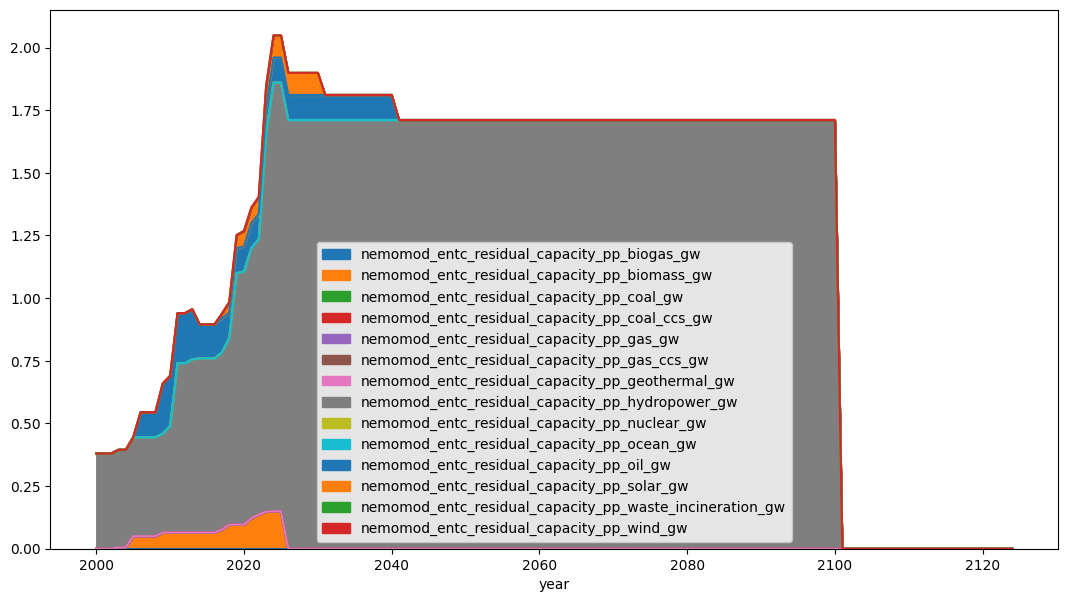

In [246]:
fig, ax = plt.subplots(figsize = (13, 7))
df_installed_capacity_out.plot.area(x = time_periods.field_year, ax = ax, )

In [245]:
# set a dictionary for converting types 
dict_seps = {
    # biomass plants
    "Bagasse Electricity- Cogeneration": "pp_biomass", 
    "Biomass- Biomass": "pp_biomass",

    # hydropower plants
    "Hydro electricity - Large Hydros": "pp_hydropower",
    "Hydro-Electricity - Mini-hydros": "pp_hydropower",
    "Hydro Electricity- Minihydros": "pp_hydropower",

    # oil
    "Thermal Electricity- Thermal": "pp_oil",
    
    # solar
    "Solar PV": "pp_solar",
}




##  BUILD NEW COLUMN AND ESTIMATE RESIDUAL CAPACITY FORWARD

class_assign = None
class_cur = None

dict_tech_to_lifespan = attr_entc.field_maps.get(
    f"{_FIELD_SSP_ENTC}_to_{_FIELD_OPERATIONAL_LIFE}"
)


col_new = [_FLAG_DROP for x in range(df_installed_capacity.shape[0])]


df_installed_capacity_out = df_installed_capacity.copy()

for i, row in df_installed_capacity.iterrows():

    # check technology
    tech = row[_FIELD_ERA_TECH]
    if tech == _FLAG_OVERALL_CAPACITY:
        continue

    # class to assign
    class_cur = dict_seps.get(tech)
    class_assign = (
        class_cur
        if class_cur is not None
        else class_assign
    )
    if class_assign is None:
        continue

    # check not na
    n_not_na = len(row[fields_capacity_year].dropna())
    if (n_not_na == 0):
        if (class_cur is None): print(f"\tCheck tech {tech} at row {i}")
        continue

    
    #
    col_new[i] = class_assign


    # then, extend estimates
    vec_capacity = row[fields_ic_year].to_numpy().astype(float)
    w = np.where(~np.isnan(vec_capacity))[0]

    w_built = w[0]
    field_0 = fields_ic_year[w_built]
    
    # case where it exists in first element and the end date is included in observations
    if (w[0] == 0) & np.isnan(row[max(fields_capacity_year_base)]):
        df_installed_capacity_out.iloc[i].fillna(0.0, inplace = True)
        continue

    # field_end is guaranteed to exist based on how it was defined
    lifespan = dict_tech_to_lifespan.get(class_assign)
    field_end = min(fields_capacity_year_base) + lifespan

    for field in range(field_0, field_end + 1):
        ind = field - field_0
        if np.isnan(row[field]):
            row[field] = row[field - 1]
    

    df_installed_capacity_out.iloc[i] = row    
    
    

# formatting and aggregation
df_installed_capacity_out[_FIELD_SSP_ENTC] = col_new
df_installed_capacity_out = df_installed_capacity_out[
    ~df_installed_capacity_out[_FIELD_SSP_ENTC].isin([_FLAG_DROP])
]

# dictionary to rename fields
dict_rnm = {"index": time_periods.field_year}
dict_rnm.update(
    matt.get_category_replacement_field_dict(modvar_rc, )
)

df_installed_capacity_out = (
    df_installed_capacity_out
    .drop(columns = [_FIELD_ERA_TECH], )
    .groupby([_FIELD_SSP_ENTC])
    .sum()
    .transpose()
    .reset_index()
    .rename(columns = dict_rnm, )
)

df_installed_capacity_out.columns.name = None


# finally, extract available and fill missing fields with 0
df_installed_capacity_out = modvar_rc.get_from_dataframe(
    df_installed_capacity_out, 
    extraction_logic = "any_fill", 
    fields_additional = [time_periods.field_year],
    fill_value = 0.0,
)


##  FINALLY, IMPORTANTLY, DO UNITS CONVERSION

units = matt.get_unit("power")
scalar = units.convert(_UNITS_DATASET_ERA, modvar_rc.attribute("unit_power"))
df_installed_capacity_out[modvar_rc.fields] *= scalar

# Write Output

In [247]:
df_installed_capacity_out.to_csv(
    cdn._PATH_OUTPUTS.joinpath(f"{modvar_rc.name_fs_safe.upper()}.csv"),
    encoding = "UTF-8",
    index = None,
)